In [5]:
!pip install pandas

   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
    --------------------------------------- 0.3/11.0 MB ? eta -:--:--
   -- ------------------------------------- 0.8/11.0 MB 2.6 MB/s eta 0:00:04
   -------- ------------------------------- 2.4/11.0 MB 5.0 MB/s eta 0:00:02
   --------------------------- ------------ 7.6/11.0 MB 11.5 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 13.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   ------ --------------------------------- 2.1/12.8 MB 9.8 MB/s eta 0:00:02
   -------- ------------------------------- 2.6/12.8 MB 5.4 MB/s eta 0:00:02
   ---------- ----------------------------- 3.4/12.8 MB 5.4 MB/s eta 0:00:02
   -------------- ------------------------- 4.7/12.8 MB 5.5 MB/s eta 0:00:02
   ------------------ --------------------- 5.8/12.8 MB 5.2 MB/s eta 0:00:02
   ------------------- -------------------- 6.3/12.8 MB 5.1 MB/s eta 0:00:02
   --------------


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import pandas as pd

In [13]:
import os
os.getcwd()

'C:\\Users\\dell\\all\\Desktop\\2025_Mphil\\RivBasMan\\volta-inflow-prediction\\volta-project\\Volta-Inflow-Prediction\\notebooks'

In [7]:
import pandas as pd
import numpy as np
import os

print("--- Starting Data Processing Pipeline ---")

# =================================================================
# 1. DEFINE THE CLEANING FUNCTION
# =================================================================
def process_grdc_file(file_path):
    try:
        df = pd.read_csv(file_path, comment='#', sep=';', header=None, names=['date', 'time', 'discharge_m3/s'], encoding='latin1')
        df_clean = df.iloc[1:].copy()
        df_clean = df_clean.drop(columns=['time'])
        df_clean['date'] = pd.to_datetime(df_clean['date'])
        df_clean['discharge_m3/s'] = pd.to_numeric(df_clean['discharge_m3/s'])
        df_clean.set_index('date', inplace=True)
        return df_clean
    except Exception as e:
        print(f"Error processing {os.path.basename(file_path)}: {e}")
        return None

# =================================================================
# 2. LOAD AND CLEAN ALL RAW DATA
# =================================================================
# Load Discharge Data
station_path = '../data/raw/1531450_Q_Day.Cmd.txt'
df_discharge = process_grdc_file(station_path).rename(columns={'discharge_m3/s': 'discharge'})
print("✅ Discharge data loaded and cleaned.")

# Load Rainfall Data
rainfall_path = '../data/processed/Volta_Basin_Daily_Rainfall_1981_2023.csv'
df_rainfall = pd.read_csv(rainfall_path, index_col='date', parse_dates=True)
print("✅ Rainfall data loaded.")

# Load and Clean SOI Data
soi_path = '../data/raw/soi.long.csv'
df_soi = pd.read_csv(soi_path)
df_soi.columns = df_soi.columns.str.strip()
date_str_fixed = df_soi['Date'].str[:-1] + '1'
df_soi['date'] = pd.to_datetime(date_str_fixed)
value_col_name = [col for col in df_soi.columns if col not in ['Date', 'date']][0]
df_soi = df_soi.rename(columns={value_col_name: 'soi_index'})
df_soi = df_soi[['date', 'soi_index']]
df_soi.set_index('date', inplace=True)
df_soi_daily = df_soi.resample('D').ffill()
print("✅ SOI data loaded and cleaned.")

# =================================================================
# 3. MERGE DATASETS
# =================================================================
df_master = df_discharge.join(df_rainfall, how='inner').join(df_soi_daily, how='inner')
print("✅ All datasets merged into df_master.")

# =================================================================
# =================================================================
# 4. PERFORM FEATURE ENGINEERING (UPDATED)
# =================================================================
print("Selecting core numeric columns for modeling...")

# --- THIS IS THE NEW, FIXING LINE ---
# We select only the columns we actually need for the model before creating features.
df_master = df_master[['discharge', 'rainfall_mm', 'soi_index']]
# ------------------------------------

df_model = df_master.copy()
for i in range(1, 8):
    df_model[f'discharge_lag_{i}'] = df_model['discharge'].shift(i)
    df_model[f'rainfall_lag_{i}'] = df_model['rainfall_mm'].shift(i)

df_model['rainfall_ma_7'] = df_model['rainfall_mm'].rolling(window=7).mean()
df_model['rainfall_ma_30'] = df_model['rainfall_mm'].rolling(window=30).mean()
df_model['month'] = df_model.index.month
df_model['target_discharge_t+7'] = df_model['discharge'].shift(-7)
df_model.dropna(inplace=True)
print("✅ Feature engineering complete.")

--- Starting Data Processing Pipeline ---
✅ Discharge data loaded and cleaned.
✅ Rainfall data loaded.
✅ SOI data loaded and cleaned.
✅ All datasets merged into df_master.
Selecting core numeric columns for modeling...
✅ Feature engineering complete.


In [15]:
import os
# List all files and folders one level up from our notebook
os.listdir('../')

['.git',
 '.gitignore',
 '.ipynb_checkpoints',
 '01-Data-Cleaning.ipynb',
 'data',
 'figures',
 'notebooks',
 'README.md',
 'scripts']

In [5]:
import pandas as pd

# Define the relative path to your file
file_path = '../data/raw/1531300_Q_Day.Cmd.txt'

# Read the data, now specifying the correct encoding
df_station1 = pd.read_csv(
    file_path,
    comment='#',
    sep=';',
    header=None,
    names=['date', 'time', 'discharge_m3/s'],
    parse_dates=['date'],
    encoding='latin1'  # <-- This is the magic line!
)

# If the code reaches here, it worked!
print("Success! Data loaded correctly. Here is a preview:")
df_station1.head()

Success! Data loaded correctly. Here is a preview:


C:\Users\dell\AppData\Local\Temp\ipykernel_26680\1671446670.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_station1 = pd.read_csv(


,date,time,discharge_m3/s
0,YYYY-MM-DD,hh:mm,Value
1,1998-10-28,--:--,86.722
2,1998-10-29,--:--,82.388
3,1998-10-30,--:--,77.804
4,1998-10-31,--:--,72.236


In [20]:
# The DataFrame we loaded is in the variable 'df_station1'.
# Let's create a new, clean version.

# 1. The first row (index 0) is a junk header. We'll select everything
#    from the second row (index 1) onwards using '.iloc[1:]'.
#    The '.copy()' prevents a common pandas warning.
df_clean = df_station1.iloc[1:].copy()

# 2. The 'time' column has no useful information ('--:--'), so we'll drop it.
df_clean = df_clean.drop(columns=['time'])

# 3. Now that the junk row is gone, let's make sure the 'date' column
#    is treated as a proper date object.
df_clean['date'] = pd.to_datetime(df_clean['date'])

# 4. Similarly, let's ensure the 'discharge_m3/s' column is a number.
df_clean['discharge_m3/s'] = pd.to_numeric(df_clean['discharge_m3/s'])

# 5. The final, most important step: set the 'date' column as the
#    official index of the table. This makes it a true time series.
df_clean.set_index('date', inplace=True)


# --- Let's verify our work ---
print("--- Cleaned DataFrame Info ---")
df_clean.info()

print("\n--- Cleaned DataFrame Preview ---")
df_clean.head()

--- Cleaned DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3046 entries, 1998-10-28 to 2007-02-28
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   discharge_m3/s  3046 non-null   float64
dtypes: float64(1)
memory usage: 47.6 KB

--- Cleaned DataFrame Preview ---


,discharge_m3/s
date,
1998-10-28,86.722
1998-10-29,82.388
1998-10-30,77.804
1998-10-31,72.236
1998-11-01,65.975


In [21]:
import pandas as pd
import os

def process_grdc_file(file_path):
    """
    Loads a GRDC .Cmd.txt file, cleans it, and returns a time-series DataFrame.
    """
    try:
        # Step 1: Read the messy file
        df = pd.read_csv(
            file_path,
            comment='#',
            sep=';',
            header=None,
            names=['date', 'time', 'discharge_m3/s'],
            encoding='latin1'
        )
        
        # Step 2: Clean the data
        df_clean = df.iloc[1:].copy()
        df_clean = df_clean.drop(columns=['time'])
        df_clean['date'] = pd.to_datetime(df_clean['date'])
        df_clean['discharge_m3/s'] = pd.to_numeric(df_clean['discharge_m3/s'])
        df_clean.set_index('date', inplace=True)
        
        return df_clean
    except Exception as e:
        print(f"Error processing {os.path.basename(file_path)}: {e}")
        return None

In [22]:
# Define the path to your raw data
raw_data_path = '../data/raw/'

# Find all the daily discharge files
# We'll look for any filename that contains "Q_Day"
station_files = [f for f in os.listdir(raw_data_path) if 'Q_Day' in f]

# A dictionary to hold our clean DataFrames, with the station ID as the key
all_stations_df = {}

print("Processing station files...")
for filename in station_files:
    # Extract the station ID from the filename (e.g., '1531300')
    station_id = filename.split('_')[0]
    
    # Create the full path to the file
    full_path = os.path.join(raw_data_path, filename)
    
    # Use our function to process the file
    cleaned_df = process_grdc_file(full_path)
    
    # Add the result to our dictionary
    if cleaned_df is not None:
        all_stations_df[station_id] = cleaned_df
        print(f"  -> Successfully processed station {station_id}")

print("\nAll station data is now loaded and cleaned!")

Processing station files...
  -> Successfully processed station 1531300
  -> Successfully processed station 1531450
  -> Successfully processed station 1531550
  -> Successfully processed station 1531600
  -> Successfully processed station 1531800

All station data is now loaded and cleaned!


In [24]:
!pip install matplotlib

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 1.7 MB/s eta 0:00:05
   ------ --------------------------------- 1.3/8.1 MB 2.8 MB/s eta 0:00:03
   ---------------- ----------------------- 3.4/8.1 MB 5.4 MB/s eta 0:00:01
   -------------------------------------- - 7.9/8.1 MB 9.7 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 9.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 64.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   ------------------------- -------------- 4.5/7.0 MB 67.7 MB/s eta 0:00:01
   ---------------------------------------- 7.0/7.0 MB 15.9 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
!pip install seaborn


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


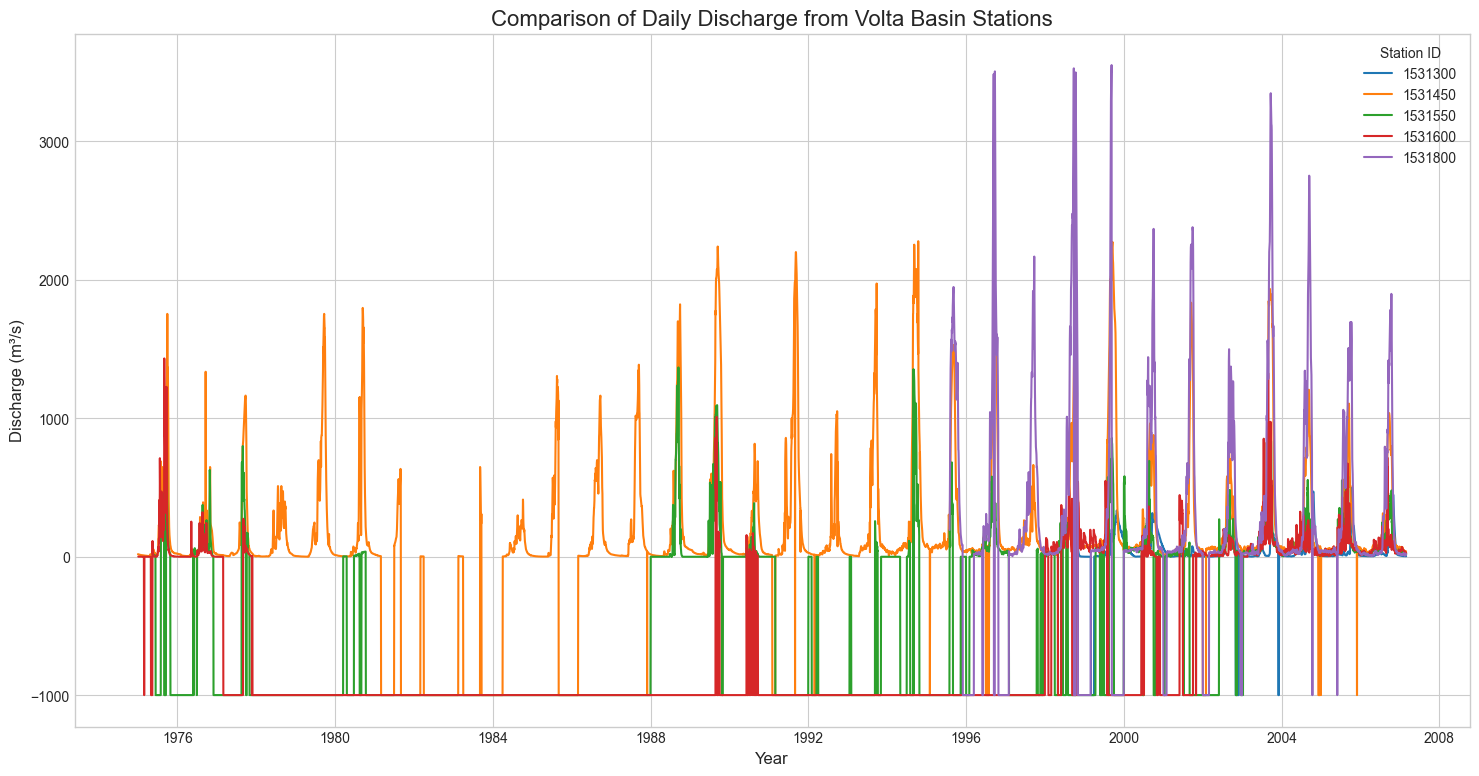

In [26]:
import matplotlib.pyplot as plt

# Set up the plot size for better viewing
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(18, 9))

# Plot each station's data
for station_id, df in all_stations_df.items():
    plt.plot(df.index, df['discharge_m3/s'], label=station_id)

# Add titles and labels to make the plot professional
plt.title('Comparison of Daily Discharge from Volta Basin Stations', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Discharge (m³/s)', fontsize=12)
plt.legend(title='Station ID')
plt.show()

In [28]:
!pip install ee

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for ee: filename=ee-0.2-py3-none-any.whl size=3706 sha256=ee29ea4fbb6f10458e5d8393cb143cf1aac5c6386245277dfb96807d064cf946
  Stored in directory: c:\users\dell\appdata\local\pip\cache\wheels\68\e5\fb\285c24eaa7ce9d3844e311635dea798b3c4c9ceb6c32cd1da4
Successfully built ee



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
import ee
import pandas as pd

# --- This will trigger the authentication flow ---
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()
# -------------------------------------------------

print("Successfully connected to Google Earth Engine.")

# Define the Volta Basin boundary (a rough bounding box)
# We can refine this later with a proper shapefile for more accuracy
volta_basin = ee.Geometry.Rectangle([-5.5, 4.5, 2.0, 11.5]) # [minLon, minLat, maxLon, maxLat]

# Load the CHIRPS rainfall dataset and filter it by date
chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
            .filter(ee.Filter.date('1981-01-01', '2023-12-31'))

# This is a function that GEE applies to every image (every day) in the dataset
def calculate_daily_rainfall(image):
    # Calculate the mean rainfall within our defined Volta Basin
    mean_rainfall = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=volta_basin,
        scale=5566  # CHIRPS resolution in meters
    ).get('precipitation')
    
    # Return a feature with the date and the calculated rainfall value
    return ee.Feature(None, {
        'date': image.date().format('YYYY-MM-dd'),
        'rainfall_mm': mean_rainfall
    })

# Apply this function to the entire collection
daily_rainfall_features = chirps.map(calculate_daily_rainfall)

# --- Important Part: Get data from GEE servers to our notebook ---
print("Fetching rainfall data from GEE... This may take a moment.")
results = daily_rainfall_features.getInfo()
print("Data fetch complete!")

# Convert the results into a pandas DataFrame
rainfall_list = [f['properties'] for f in results['features']]
df_rainfall = pd.DataFrame(rainfall_list)

# Clean up the DataFrame
df_rainfall['date'] = pd.to_datetime(df_rainfall['date'])
df_rainfall.set_index('date', inplace=True)

# Save the processed data to a new file
output_path = '../data/processed/volta_basin_daily_rainfall_1981_2023.csv'
df_rainfall.to_csv(output_path)


# --- Verify our work ---
print(f"\nSuccessfully saved rainfall data to: {output_path}")
print("Here is a preview of the rainfall data:")
df_rainfall.head()

C:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\ee\main.py:150: SyntaxWarning: invalid escape sequence '\d'
  lines = filter(lambda x: re.match("^\d+ bytes", x), data.splitlines())


ModuleNotFoundError: No module named '_curses'

In [30]:
!pip install curses

ERROR: Could not find a version that satisfies the requirement curses (from versions: none)

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for curses


In [31]:
!pip install windows-curses


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# Initialize the connection, telling it which project to use.
ee.Initialize(project='enduring-trees-47')

print("Successfully connected to Google Earth Engine.")

# --- The rest of your code remains the same ---

NameError: name 'ee' is not defined

In [2]:
import pandas as pd

# Load the SOI data (adjust filename if necessary)
soi_path = '../data/raw/soi.long.csv'
df_soi = pd.read_csv(soi_path)

# The SOI file often has column names on two lines. Let's fix that.
# We'll create a proper 'date' column from the 'Year' and 'Month' columns.
df_soi['date'] = pd.to_datetime(df_soi['Year'].astype(str) + '-' + df_soi['Month'].astype(str) + '-01')

# We only need the date and the SOI value
df_soi = df_soi[['date', 'Value']].rename(columns={'Value': 'soi_index'})
df_soi.set_index('date', inplace=True)

# Resample the monthly data to daily using forward-fill
df_soi_daily = df_soi.resample('D').ffill()

print("SOI data cleaned and resampled to daily:")
df_soi_daily.head()

KeyError: 'Year'

In [3]:
import pandas as pd

# Load the SOI data
soi_path = '../data/raw/soi.long.csv'
df_soi_inspect = pd.read_csv(soi_path)

# See the first 5 rows
print("--- DataFrame Preview ---")
print(df_soi_inspect.head())

# See the actual column names
print("\n--- Actual Column Names ---")
print(df_soi_inspect.columns)


--- DataFrame Preview ---
         Date  \
0  1866-01-01   
1  1866-02-01   
2  1866-03-01   
3  1866-04-01   
4  1866-05-01   

    SOI from CRU  missing value -99.99 https://psl.noaa.gov/data/timeseries/month/  
0                                              -0.62                                
1                                              -0.12                                
2                                              -0.62                                
3                                              -0.65                                
4                                               0.04                                

--- Actual Column Names ---
Index(['Date', ' SOI from CRU  missing value -99.99 https://psl.noaa.gov/data/timeseries/month/'], dtype='object')


In [3]:
# Rerun this cell in your 01-Data-Cleaning.ipynb notebook

import numpy as np
df_model = df_master.copy()

# 1. Create Lag Features
for i in range(1, 8):
    df_model[f'discharge_lag_{i}'] = df_model['discharge'].shift(i)
    df_model[f'rainfall_lag_{i}'] = df_model['rainfall_mm'].shift(i)

# 2. Create Moving Average Features
df_model['rainfall_ma_7'] = df_model['rainfall_mm'].rolling(window=7).mean()
df_model['rainfall_ma_30'] = df_model['rainfall_mm'].rolling(window=30).mean()

# 3. Create Time-Based Features
df_model['month'] = df_model.index.month

# 4. Create the Target Variable (y)
df_model['target_discharge_t+7'] = df_model['discharge'].shift(-7)

# --- Clean Up ---
df_model.dropna(inplace=True)
print("✅ Feature engineering complete. df_model is ready.")


NameError: name 'df_master' is not defined

In [9]:
import pandas as pd

# Load the SOI data
soi_path = '../data/raw/soi.long.csv'
df_soi = pd.read_csv(soi_path)

# --- Clean up column names to remove hidden spaces ---
df_soi.columns = df_soi.columns.str.strip()
print(f"Cleaned column names are: {df_soi.columns.to_list()}")

# --- Fix the non-standard date format reliably ---
date_str_fixed = df_soi['Date'].str[:-1] + '1'
df_soi['date'] = pd.to_datetime(date_str_fixed)

# --- NEW: Automatically find and rename the value column ---
# Find the name of the column that is not 'Date' or our new 'date'
try:
    value_col_name = [col for col in df_soi.columns if col not in ['Date', 'date']][0]
    print(f"Automatically detected value column: '{value_col_name}'")
    # Rename the detected column to 'soi_index'
    df_soi = df_soi.rename(columns={value_col_name: 'soi_index'})
except IndexError:
    print("Error: Could not automatically detect the value column.")
    # You can inspect the DataFrame here if needed
    # print(df_soi.head())


# --- Final Steps ---
# Keep only the two columns we need
df_soi = df_soi[['date', 'soi_index']]
df_soi.set_index('date', inplace=True)

# Resample the monthly data to daily using forward-fill
df_soi_daily = df_soi.resample('D').ffill()

print("\n✅ SOI data cleaned and resampled to daily:")
df_soi_daily.head()

Cleaned column names are: ['Date', 'SOI from CRU  missing value -99.99 https://psl.noaa.gov/data/timeseries/month/']
Automatically detected value column: 'SOI from CRU  missing value -99.99 https://psl.noaa.gov/data/timeseries/month/'

✅ SOI data cleaned and resampled to daily:


,soi_index
date,
1866-01-01,-0.62
1866-01-02,-0.62
1866-01-03,-0.62
1866-01-04,-0.62
1866-01-05,-0.62


In [11]:
def process_grdc_file(file_path):
    """
    Loads a GRDC .Cmd.txt file, cleans it, and returns a time-series DataFrame.
    """
    try:
        # Step 1: Read the messy file
        df = pd.read_csv(
            file_path,
            comment='#',
            sep=';',
            header=None,
            names=['date', 'time', 'discharge_m3/s'],
            encoding='latin1'
        )
        
        # Step 2: Clean the data
        df_clean = df.iloc[1:].copy()
        df_clean = df_clean.drop(columns=['time'])
        df_clean['date'] = pd.to_datetime(df_clean['date'])
        df_clean['discharge_m3/s'] = pd.to_numeric(df_clean['discharge_m3/s'])
        df_clean.set_index('date', inplace=True)
        
        return df_clean
    except Exception as e:
        print(f"Error processing {os.path.basename(file_path)}: {e}")
        return None

In [12]:
# The function 'process_grdc_file' should already exist in a cell above.
# We'll just call it with the correct file path.
station_path = '../data/raw/1531450_Q_Day.Cmd.txt'
df_discharge = process_grdc_file(station_path).rename(columns={'discharge_m3/s': 'discharge'})

print("✅ Chosen discharge station (1531450) loaded:")
df_discharge.head()

✅ Chosen discharge station (1531450) loaded:


,discharge
date,
1975-01-01,18.480
1975-01-02,18.480
1975-01-03,17.065
1975-01-04,17.065
1975-01-05,17.065


In [16]:
import ee
import pandas as pd

# Use the project ID you found earlier
ee.Initialize(project='enduring-trees-475113-j3') # <-- IMPORTANT: Put your project ID here
print("Successfully connected to Google Earth Engine.")

# Define the Volta Basin boundary
volta_basin = ee.Geometry.Rectangle([-5.5, 4.5, 2.0, 11.5])

# Filter the CHIRPS rainfall dataset by date
chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
            .filter(ee.Filter.date('1981-01-01', '2023-12-31'))

# This function calculates the average rainfall for each day
def calculate_daily_rainfall(image):
    mean_rainfall = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=volta_basin,
        scale=5566
    ).get('precipitation')
    return ee.Feature(None, {
        'date': image.date().format('YYYY-MM-dd'),
        'rainfall_mm': mean_rainfall
    })

daily_rainfall_features = chirps.map(calculate_daily_rainfall)

# --- This creates an export "task" ---
task = ee.batch.Export.table.toDrive(
    collection=daily_rainfall_features,
    description='Volta_Basin_Daily_Rainfall_1981_2023', # This will be the filename
    fileFormat='CSV'
)

# Start the task. This sends the job to Google's servers.
task.start()

print("✅ Task submitted successfully!")
print("Now, go to the GEE website to run and monitor the task.")

Successfully connected to Google Earth Engine.
✅ Task submitted successfully!
Now, go to the GEE website to run and monitor the task.


In [17]:
# Load the processed rainfall CSV
rainfall_path = '../data/processed/Volta_Basin_Daily_Rainfall_1981_2023.csv'
df_rainfall = pd.read_csv(rainfall_path, index_col='date', parse_dates=True)

print("✅ Processed rainfall data loaded:")
df_rainfall.head()

✅ Processed rainfall data loaded:


,system:index,rainfall_mm,.geo
date,,,
1981-01-01,19810101,0.024594,"{""type"":""MultiPoint"",""coordinates"":[]}"
1981-01-02,19810102,0.000007,"{""type"":""MultiPoint"",""coordinates"":[]}"
1981-01-03,19810103,0.000000,"{""type"":""MultiPoint"",""coordinates"":[]}"
1981-01-04,19810104,0.343530,"{""type"":""MultiPoint"",""coordinates"":[]}"
1981-01-05,19810105,0.002130,"{""type"":""MultiPoint"",""coordinates"":[]}"


In [18]:
# The variable 'df_soi_daily' should still be in memory from the previous step.
# Let's combine all three sources.
df_master = df_discharge.join(df_rainfall, how='inner').join(df_soi_daily, how='inner')

# Let's check for any remaining missing values and see our final dataset
print("--- Master DataFrame Info ---")
df_master.info()

print("\n--- Master DataFrame Preview ---")
df_master.head()

--- Master DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9555 entries, 1981-01-01 to 2007-02-28
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   discharge     9555 non-null   float64
 1   system:index  9555 non-null   int64  
 2   rainfall_mm   9555 non-null   float64
 3   .geo          9555 non-null   object 
 4   soi_index     9555 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 447.9+ KB

--- Master DataFrame Preview ---


,discharge,system:index,rainfall_mm,.geo,soi_index
date,,,,,
1981-01-01,17.065,19810101,0.024594,"{""type"":""MultiPoint"",""coordinates"":[]}",0.27
1981-01-02,17.065,19810102,0.000007,"{""type"":""MultiPoint"",""coordinates"":[]}",0.27
1981-01-03,17.065,19810103,0.000000,"{""type"":""MultiPoint"",""coordinates"":[]}",0.27
1981-01-04,16.386,19810104,0.343530,"{""type"":""MultiPoint"",""coordinates"":[]}",0.27
1981-01-05,16.386,19810105,0.002130,"{""type"":""MultiPoint"",""coordinates"":[]}",0.27


In [8]:
# Define the path for our final, model-ready dataset
output_path = '../data/processed/model_ready_data.csv'

# Save the DataFrame to a CSV file
df_master.to_csv(output_path)

print(f"✅ Model-ready data successfully saved to: {output_path}")

✅ Model-ready data successfully saved to: ../data/processed/model_ready_data.csv


In [9]:
import pandas as pd
import numpy as np
import os

print("--- Starting FINAL Data Processing Pipeline ---")

# =================================================================
# 1. DEFINE THE CLEANING FUNCTION
# =================================================================
def process_grdc_file(file_path):
    try:
        df = pd.read_csv(file_path, comment='#', sep=';', header=None, names=['date', 'time', 'discharge_m3/s'], encoding='latin1')
        df_clean = df.iloc[1:].copy()
        df_clean = df_clean.drop(columns=['time'])
        df_clean['date'] = pd.to_datetime(df_clean['date'])
        df_clean['discharge_m3/s'] = pd.to_numeric(df_clean['discharge_m3/s'])
        df_clean.set_index('date', inplace=True)
        return df_clean
    except Exception as e:
        return None

# =================================================================
# 2. LOAD AND CLEAN ALL RAW DATA
# =================================================================
station_path = '../data/raw/1531450_Q_Day.Cmd.txt'
df_discharge = process_grdc_file(station_path).rename(columns={'discharge_m3/s': 'discharge'})
rainfall_path = '../data/processed/Volta_Basin_Daily_Rainfall_1981_2023.csv'
df_rainfall = pd.read_csv(rainfall_path, index_col='date', parse_dates=True)
soi_path = '../data/raw/soi.long.csv'
df_soi = pd.read_csv(soi_path)
df_soi.columns = df_soi.columns.str.strip()
date_str_fixed = df_soi['Date'].str[:-1] + '1'
df_soi['date'] = pd.to_datetime(date_str_fixed)
value_col_name = [col for col in df_soi.columns if col not in ['Date', 'date']][0]
df_soi = df_soi.rename(columns={value_col_name: 'soi_index'})
df_soi = df_soi[['date', 'soi_index']]
df_soi.set_index('date', inplace=True)
df_soi_daily = df_soi.resample('D').ffill()
print("✅ Raw data loaded and cleaned.")

# =================================================================
# 3. MERGE AND PREPARE FOR FEATURE ENGINEERING
# =================================================================
df_master = df_discharge.join(df_rainfall, how='inner').join(df_soi_daily, how='inner')
df_numeric = df_master[['discharge', 'rainfall_mm', 'soi_index']]
print("✅ Datasets merged and numeric columns selected.")

# =================================================================
# 4. PERFORM FEATURE ENGINEERING
# =================================================================
df_model = df_numeric.copy()
for i in range(1, 8):
    df_model[f'discharge_lag_{i}'] = df_model['discharge'].shift(i)
    df_model[f'rainfall_lag_{i}'] = df_model['rainfall_mm'].shift(i)
df_model['rainfall_ma_7'] = df_model['rainfall_mm'].rolling(window=7).mean()
df_model['rainfall_ma_30'] = df_model['rainfall_mm'].rolling(window=30).mean()
df_model['month'] = df_model.index.month
df_model['target_discharge_t+7'] = df_model['discharge'].shift(-7) # Target column created here
df_model.dropna(inplace=True)
print("✅ Feature engineering complete. Target column created.")

# =================================================================
# 5. SAVE THE FINAL, MODEL-READY DATA
# =================================================================
output_path = '../data/processed/model_ready_data.csv'
df_model.to_csv(output_path)
print("\n--- PIPELINE COMPLETE! ---")
print(f"✅ Final data saved to: {output_path}")

# --- Verification Step ---
df_check = pd.read_csv(output_path)
print("\n--- Verification of Saved File ---")
print("Columns in saved CSV file:", df_check.columns.to_list())

--- Starting FINAL Data Processing Pipeline ---
✅ Raw data loaded and cleaned.
✅ Datasets merged and numeric columns selected.
✅ Feature engineering complete. Target column created.

--- PIPELINE COMPLETE! ---
✅ Final data saved to: ../data/processed/model_ready_data.csv

--- Verification of Saved File ---
Columns in saved CSV file: ['date', 'discharge', 'rainfall_mm', 'soi_index', 'discharge_lag_1', 'rainfall_lag_1', 'discharge_lag_2', 'rainfall_lag_2', 'discharge_lag_3', 'rainfall_lag_3', 'discharge_lag_4', 'rainfall_lag_4', 'discharge_lag_5', 'rainfall_lag_5', 'discharge_lag_6', 'rainfall_lag_6', 'discharge_lag_7', 'rainfall_lag_7', 'rainfall_ma_7', 'rainfall_ma_30', 'month', 'target_discharge_t+7']
